# Figure 1: Integrated ocean heat content over upper 700m in Indian Ocean

This notebook contains the full code used on the original data (too large to make available) for completeness.  
To repoduce figure jump to **plotting section** where provided files can be loaded.  

For Figure S1 mask and baselines have been adjusted in this script!

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import cmocean as cmo
import numpy as np
import cartopy.crs as ccrs
import cartopy
import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from scipy.interpolate import griddata
# from scipy.io import loadmat
import datetime
import string

import sys
sys.path.append("./")  # adds upper level to working directory\n
from utils_iohc_ummenhofer2020 import deseason,ohc_anomaly,cut_indo,plot_map,finished_plot


# where to save plots
plotsave = 'plots/'
datapath = '/vortexfs1/share/clidex/data/'

In [2]:
# baseline period for anomalies
base = ['1960-01-01','2012-12-31']

# values for heat content calculation
cp = 3994 # heat capacity
rho = 1029 # reference density
# cp and rho from https://xgcm.readthedocs.io/en/latest/example_eccov4.html

# masks
masktype = 'orca' # 'levitus'
if masktype=='orca': mask = xr.open_dataset(datapath+'ORCA/mesh_files/new_maskglo.nc')
elif masktype=='levitus': mask = xr.open_dataset('./data/mask_ind_levitus_orca.nc')

Levitus OHC comes only for larger basin mask extending across Southern Ocean (Levitus mask goes from 20E to 146.5E), where as ORCA only goes to ~33S


# Model data

In [3]:
################### load data ######################
zrange = slice(0,22)
datapath2 = datapath+'publications/IOHC_Ummenhofer/'
k003 = xr.open_dataset(datapath2 + '/K003.hindcast_temp_IndoPacific_30E_150W_70S_30N.nc',
                      chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)
k004 = xr.open_dataset(datapath2 + 'K004.thermhal90_temp_IndoPacific_30E_150W_70S_30N.nc',
                     chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)
k005 = xr.open_dataset(datapath2 + 'K005.wind90_temp_IndoPacific_30E_150W_70S_30N.nc',
                      chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)


###############################################################################
############################# load mask ########################################
###############################################################################
# load mask
%timeit
# rename dimesion to match
mask_orca = mask.rename({'X':'x', 'Y':'y'}).drop(['x','y'])
# cut out indo region
mask_orca = cut_indo(mask_orca['tmaskind']).to_dataset()

###############################################################################
############################ load mesh variables ###############################
###############################################################################

# horizontal 
meshpath = datapath+'ORCA/mesh_files/'
mesh = xr.open_dataset(meshpath + 'mesh_hgr.nc').sel(z=zrange)
# spatical weights (e1t=zonal, e2t=meridional)
e2t = mesh['e2t']
e2t = e2t.rename({'t':'time_counter'}).squeeze()
e1t = mesh['e1t']
e1t = e1t.rename({'t':'time_counter'}).squeeze()

# vertical
mesh = xr.open_dataset(meshpath + 'mesh_zgr.nc').sel(z=zrange)
# vertical weight
e3t = mesh['e3t_0']
e3t = e3t.rename({'t':'time_counter', 'z':'deptht'})
e3t = e3t.squeeze()

# also need to cut weights for multiplication
w3 = cut_indo(e3t).to_dataset()
w3["deptht"] = k003['deptht']
w2 = cut_indo(e2t)
w1 = cut_indo(e1t)
# temperature mask (not sure what this does exactly)
tmask = xr.open_dataset(meshpath + 'mask.nc')['tmask'].isel(z=zrange)
tmask = cut_indo(tmask)
tmask = np.squeeze(tmask.rename({'z':'deptht'}))


## Derive heat content anomaly

In [ ]:
# prepare weights for 3D averaging
weights = w2.values * w1.values * w3['e3t_0'].values * tmask

# derive ocean heat content anomaly for given baseline
ohc_k003_700 = ohc_anomaly(k003['votemper'],mask_orca,weights=weights,dims=['deptht','y','x'],
                           base=base).load()

# save to netcdf
ohc_k003_700.to_dataset(name='OHC700').to_netcdf('../data/k003_ohca700_IndianOcean_timeseries_base_1960_2012.nc')

# Additional data products (observations/reanalyses)

We are using the following datasets:  
- ORCA hindcast     **1958-2016
- Levitus (WOA)  
- ORAS5 (reanalysis) 
- Ishii (WOA + ...) **1945-2012
- ISAS15 (Argo)     **2002-2015
- IAP (Cheng et al, obs plus model used for interpolation)

## ORAS5

ORAS5 comes with ocean heat content variable! Reanalysis is also produced in ORCA025 grid.

In [11]:
# load ORAS5 data
oras = xr.open_dataset(datapath+'reanalysis/oras5/ORCA025/sohtc700/opa0/sohtc700_ORAS5_1m_1979_2018_grid_T_02.nc')

# use ORCA weights and mask for averaging
weights = e2t.values*e1t.values
oras_ind = ohc_anomaly(deseason(oras,refperiod=base),mask,weights=weights,dims=['x','y'],
                       cp=1,rho=1).drop('month') # cp and rho =1 since OHC already derived

# save to netcdf
oras_ind.drop('month').to_netcdf('./data/oras5_ohca700_IndianOcean_timeseries_base_1960_2012.nc')

del oras # don't need orignal variable anymore

## Ishii


https://rda.ucar.edu/datasets/ds285.3/#description  

This global data product produced by the Ishii Ocean Analyses Projectis based on salinity and temperature data from the World Ocean Database and the Atlas as well as data from the Global Temperature-Salinity in the tropical Pacific data base by IRD (Institut de recherche pour le développement, France), sea surface temperature data from Centennial in situ Observation Based Estimates (COBE) and data from ARGO profiling buoys. The aggregated data base is objectively analysed and forms a time series of monthly temperature and salinity fields on 24 depth levels of the global ocean. The XBT depth bias correction is applied in the current version. This data product is updated irregularly. The version of the data published here is v6.13. 

In [3]:
###############################################################
# 1) #################### read data ###########################
###############################################################

ishii = xr.open_dataset(datapath+'obs/Ishii/ishii_0_160E_50S_30N.nc')
#associated cell area
area = xr.open_dataset(datapath+'obs/Ishii/ishii_cellarea.nc')

###############################################################
# 2) #################### Indian Ocean mask ###########################
###############################################################
# need mask for Indian ocean, interpolate ORCA mask onto grid
xm,ym = np.meshgrid(np.arange(-179.5,180.5,1),np.arange(-89.5,90.5,1))
mask_ind = griddata((mask['NAV_LON'].values.ravel(),mask['NAV_LAT'].values.ravel()),
                      mask['tmaskind'].values.ravel(),(xm,ym),'linear')
# set nan to 0
mask_ind[np.isnan(mask_ind)]=0
mask_ind.shape
# rearrange data to match longitudes of oras5
mask1 = np.squeeze(mask_ind[:,np.where(xm[0,:]>=0)])
mask2 = np.squeeze(mask_ind[:,np.where(xm[0,:]<0)])
mask_ind2 = np.concatenate((mask1,mask2),axis=1)
# create xarray for mask
mask_ishii = xr.DataArray(mask_ind2, dims=['lat', 'lon'],coords={'lon': np.arange(0.5,360.5,1),'lat': ym[:,0]})
mask_ishii = mask_ishii.sel(lon=slice(0.5,159.5),lat=slice(-49.5,29.5))

# cut out Indian Ocean and multiply by area
ishii_ind = ishii*mask_ishii.values*area['cell_area'].values
ishii_ind = ishii_ind.where(ishii_ind['var80']>0,drop=True)

del area,mask_ind2,mask_ind,ishii


###############################################################
## 3) ####### Prepare vertical integration  ##################
###############################################################
# derive mid-layer value and layer thickness for integration
dz = np.diff(ishii_ind['depth'])
tempdz = (ishii_ind['var80'][:,:-1,:,:].values + ishii_ind['var80'][:,1:,:,:].values)/2
depthdz = (ishii_ind.depth[:-1].values + ishii_ind.depth[1:].values)/2

# create array for multiplication
dummy = np.tile(dz,(tempdz.shape[0],tempdz.shape[2],tempdz.shape[3],1))
dzm = np.moveaxis(dummy,-1,1)

# multiply with layer thickness and create xarray
tempz2 = tempdz*dzm
temp = xr.DataArray(tempz2,
                    dims=['time','depth','lat', 'lon'],
                    coords={'lon': ishii_ind.lon.values,
                           'lat': ishii_ind.lat.values,
                           'time': ishii_ind.time.values,
                           'depth': depthdz}).to_dataset(name='temp')

###############################################################
##### 4) ###### Derive ocean heat content anomaly #############
###############################################################
# cut upper 700m & derive OHC
dummy = temp.sel(depth=slice(0,701))
ohc_ishii = dummy.sum(dim=['depth','lon','lat'])*cp*rho
ohca_ishii = ohc_ishii.groupby('time.month')-ohc_ishii.sel(
            time=slice(*base)).groupby(
            'time.month').mean('time')
ohca_ishii = ohca_ishii.drop('month')

# save to netcdf
ohca_ishii.to_netcdf('./data/ishii_ohca700_IndianOcean_timeseries_base_1960_2012.nc')

del ishii_ind,ohc_ishii,dummy,temp

## Levitus

Levitus data is downloaded from NOAA, https://www.nodc.noaa.gov/OC5/3M_HEAT_CONTENT/heat_global.html
The time resolution is seasonal from 1955-present (2019).  

Data based on WOA09 and updated continuously. Associated paper: https://data.nodc.noaa.gov/woa/PUBLICATIONS/grlheat12.pdf

Reference period in https://data.nodc.noaa.gov/woa/PUBLICATIONS/grlheat12.pdf is 1955-2006

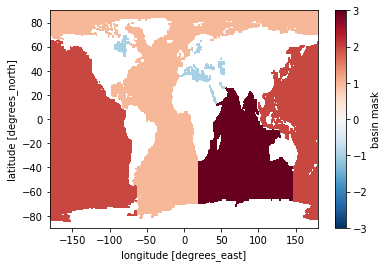

In [17]:
levitus = xr.open_dataset(datapath+'obs/Levitus/heat_content_anomaly_0-700_seasonal.nc',
                         decode_times=False)
# cannot decode 'months since...' format, so I have to create my own time vector for plotting
time_lev = pd.date_range('1955-02-01','2019-07-01' , freq='3M')

# plot basin masks
%matplotlib inline
levitus['basin_mask'].plot()

## ISAS15 - Argo data

In [14]:
###############################################################
##################### Load data ###########################
###############################################################
argo = xr.open_dataset(datapath+'obs/ARGO/ISAS15/isas15_temp_30E_160W_40S_35N.nc')
#associated cell area
argo_area = xr.open_dataset(datapath+'obs/ARGO/ISAS15/isas15_gridarea_30E_160W_40S_35N.nc')

###############################################################
##################### Indian Ocean mask ###########################
###############################################################
# need mask for Indian ocean
xm,ym = np.meshgrid(argo.longitude,argo.latitude)
mask_ind = griddata((mask['NAV_LON'].values.ravel(),mask['NAV_LAT'].values.ravel()),
                      mask['tmaskind'].values.ravel(),(xm,ym),'linear')
# set nan to 0
mask_ind[np.isnan(mask_ind)]=0
mask_ind.shape

# cut out Indian Ocean and multiply by area
argo_ind = argo*mask_ind*argo_area['cell_area'].values
argo_ind = argo_ind.where(argo_ind['TEMP']>2*1e10,drop=True)

###############################################################
###############################################################
###############################################################
# derive mid-layer value and layer thickness for integration
dz = np.diff(argo_ind['depth'])
tempdz = (argo_ind['TEMP'][:,:-1,:,:].values + argo_ind['TEMP'][:,1:,:,:].values)/2
depthdz = (argo_ind.depth[:-1].values + argo_ind.depth[1:].values)/2

# create array for multiplication
dummy = np.tile(dz,(tempdz.shape[0],tempdz.shape[2],tempdz.shape[3],1))
dzm = np.moveaxis(dummy,-1,1)

# multiply with layer thickness and create xarray
tempz2 = tempdz*dzm
temp = xr.DataArray(tempz2,
                    dims=['time','depth','latitude', 'longitude'],
                    coords={'longitude': argo_ind.longitude.values,
                           'latitude': argo_ind.latitude.values,
                           'time': argo_ind.time.values,
                           'depth': depthdz})
temp = temp.to_dataset(name='temp') # change array to dataset

###############################################################
###############################################################
###############################################################
# cut upper 700m & derive OHC
dummy = temp.sel(depth=slice(0,701))
ohc_argo = dummy.sum(dim=['depth','longitude','latitude'])*cp*rho
ohca_argo = deseason(ohc_argo,timevar='time',refperiod=base)
ohca_argo = ohca_argo.drop('month')

# save to netcdf
ohca_argo.to_netcdf('./data/argo_ohca700_IndianOcean_timeseries_base_1960_2012.nc')

del argo, argo_ind

## IAP - Cheng

In [31]:
iap = xr.open_dataset(datapath+'obs/OHC_temp_Chen/ohc/OHC700_IAP_20E_160W_72S_35N.nc')
#associated cell area
area = xr.open_dataset(datapath+'obs/OHC_temp_Chen/ohc/OHC700_IAP_gridarea_20E_160W_72S_35N.nc')

# need mask for Indian ocean, interpolate orca mask onto iap grid
xm,ym = np.meshgrid(iap.lon.values,iap.lat.values)
mask_ind = griddata((mask['NAV_LON'].values.ravel(),mask['NAV_LAT'].values.ravel()),
                      mask['tmaskind'].values.ravel(),(xm,ym),'linear')
# set nan to 0
mask_ind[np.isnan(mask_ind)]=0
mask_ind.shape

# time did not read properly --> create new time vector
time = pd.date_range('1940-01-01','2019-12-01' , freq='MS')
iap['time'] = time

iap_ind = iap['OHC700']*mask_ind*area['cell_area']
iap_ind = deseason(iap_ind,timevar='time',refperiod=base)
iap_ind = iap_ind.where(iap_ind!=0).sum(('lon','lat'))

# save to netcdf
iap_ind.drop('month').to_dataset(name='OHC700').to_netcdf('./data/iap_ohca700_IndianOcean_timeseries_base_1960_2012.nc')

# Plotting

Levitus: seasonal, i.e. Mar-1-1955,Jun-1-1955...  
Ishii: monthly, 1945-2012  
ORAS5: monthly, 1979-2018  
ISAS15: monthly, 2002-2015  
IAP: monthly, ...
  
I think reference period for Levitus is 1955-2006 (stated in paper). Or it is always full period...

In [3]:
# Model
ohc_k003_700 = xr.open_dataset('../data/k003_ohca700_IndianOcean_timeseries_base_1960_2012.nc')['OHC700']
# ORAS5
oras_ind = xr.open_dataset('../data/oras5_ohca700_IndianOcean_timeseries_base_1960_2012.nc')
# Ishii
ohca_ishii = xr.open_dataset('../data/ishii_ohca700_IndianOcean_timeseries_base_1960_2012.nc')

# ISAS15
ohca_argo = xr.open_dataset('../data/argo_ohca700_IndianOcean_timeseries_base_1960_2012.nc')['temp']
# IAP
iap_ind = xr.open_dataset('../data/iap_ohca700_IndianOcean_timeseries_base_1960_2012.nc')['OHC700']

##################
# Levitus for supplementary figure
levitus = xr.open_dataset(datapath+'obs/Levitus/heat_content_anomaly_0-700_seasonal.nc',
                         decode_times=False)
time_lev = pd.date_range('1955-02-01','2019-07-01' , freq='3M')

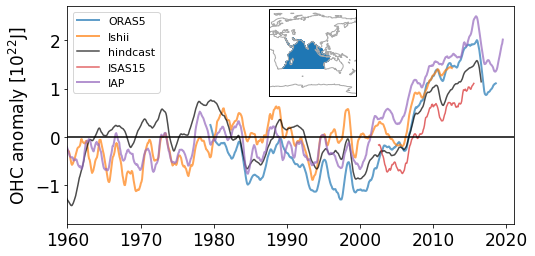

In [4]:
# Figure settings
cols = plt.get_cmap("tab10")
plt.rcParams.update({'font.size': 17})
fig1,ax1 = plt.subplots(figsize=(8,4))

# plotting data
(oras_ind['sohtc700']/1e22).rolling(time_counter=12,center=True).mean().plot(ax=ax1,label='ORAS5',linewidth=2,alpha=0.7,color=cols(0))
(ohca_ishii['temp']/1e22).rolling(time=12,center=True).mean().plot(ax=ax1,label='Ishii',linewidth=2,alpha=0.7,color=cols(1))#
# add K003
(ohc_k003_700/1e22).rolling(time_counter=12,center=True).mean().plot(ax=ax1,label='hindcast',color='k',linewidth=1.5,alpha=0.7)
# ISAS15
(ohca_argo/1e22).rolling(time=12,center=True).mean().plot(ax=ax1,label='ISAS15',color=cols(3),linewidth=1.5,alpha=0.7)
# IAP
(iap_ind/1e22).rolling(time=12,center=True).mean().plot(ax=ax1,label='IAP',
                                                        linewidth=2,alpha=0.7,
                                                       color=cols(4))
##################
# # for supplementarty figure add Leviuts
# plt.plot(time_lev,(levitus['seas_h22_IO']).rolling(time=4,center=True).mean(),label='Levitus',linewidth=2,alpha=0.7,color=cols(2))


# make plot pretty
ax1.axhline(0,color='k')
ax1.legend(loc='upper left',fontsize=11)
plt.xlabel('')
plt.ylabel('OHC anomaly [$10^{22}$J]')
plt.xlim('1960-01','2021-01')
plt.ylim(-1.8,2.7)

for label in ax1.get_xticklabels():
    label.set_ha("center")
    label.set_rotation(0)

# add map to show masks
mapax = fig1.add_axes([0.4,0.57,0.3,0.3],projection=ccrs.PlateCarree())
mapax.set_extent([0,179,-75,35])
mapax.coastlines(color='darkgray')
from matplotlib import colors as c
cMap = c.ListedColormap([cols(2)])
# levitus['basin_mask'].where(levitus['basin_mask']==3).plot.pcolormesh(ax=mapax,transform=ccrs.PlateCarree(),
#                                                                       add_colorbar=False,cmap=cMap)
mask = xr.open_dataset(datapath+'/ORCA/mesh_files/new_maskglo.nc')
cMap = c.ListedColormap([cols(0)])
lon = mask['NAV_LON'].values
lon[lon<0] = lon[lon<0]+360
mapax.pcolor(lon,mask['NAV_LAT'].values,mask['tmaskind'].where(mask['tmaskind']==1).values,
             transform=ccrs.PlateCarree(),cmap=cMap,alpha=0.5)


# save figure
year1 = datetime.datetime.strptime(base[0], '%Y-%m-%d').year
year2 = datetime.datetime.strptime(base[1], '%Y-%m-%d').year
# plt.savefig(plotsave + 'Fig1_IOHC_anomaly_700m_obs_K003_base_'+str(year1)+'_'+str(year2)+
#             '_mask_'+masktype+'.png',dpi=300,bbox_inches='tight')